# Machine Learning 2024/2025 - Progress Task 2 (Application of Light Hisogram Gradient Boosting)

## Abstract

In an attempt to achieve competitive advancements, the team decided to use some alternative models that were not present under the scikit-learn library. The LightGBM model is a decision-tree-based model from the library `lightgbm`. Given the good performance of catboost and the similarity of this other model to it, the team decided to try it out.

## Introduction

Light Gradient Boosting Machine (LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. It is designed for distributed and efficient gradient boosting, **performing even faster than catboost**. Working within the `lightgbm` library, developers are able to use the model on datasets of millions of samples efficiently, with a set of high-efficiency parameters. The model is also able to handle a methodology called "feature_fraction" which allows it to only handle a set of features within each iteration.

LightGBM uses a leave-based growth strategy, always selecting the best leaf node to divide. This approach may achieve competitive advantage over other models.

### Strengths

* **Speed**: LightGBM is known for its speed and efficiency, being able to handle large datasets with millions of samples.
* **High accuracy**: its leaf-based growth strategy allows it to achieve high accuracy.

### Weaknesses

* **Overfitting**: LightGBM is known to overfit on smaller datasets, so it is important to tune the hyperparameters correctly.
* **Sensitivity to disbalanced datasets**: class ponderation may be required.

## Methodology

The team used the K-Nearest Neighbours algorithm to classify the data. The team used the following hyperparameters:

- n_neighbors: 5
- weights: distance

## Implementation

The team used the following code to implement the K-Nearest Neighbours algorithm:

In [1]:
!pip install pandas lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 1.5 MB/s eta 0:00:0000:0100:01


### Initial Configuration

In [2]:
# IMPORTS
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.multioutput import MultiOutputClassifier
import logging
import configparser

# GLOBAL VARIABLES

# Load configuration fileconfig["data"]["targets"]
CONFIG_FILE_PATH = "mlflow/test.conf"

config = configparser.ConfigParser()
config.read(CONFIG_FILE_PATH)
DATASET_PATH = config["data"]["dataset_path"]
TEST_DATASET_PATH = config["data"]["dataset_test_path"]
DATASET_INDEX_FEATURE = config["data"]["dataset_index"]
DATASET_TARGET_FEATURES = ["h1n1_vaccine", "seasonal_vaccine"]
CONFIG_SECTION_MLFLOW = "mlflow"
CONFIG_SECTION_NAMES = "names"
CONFIG_SECTION_DATA = "data"
CONFIG_PARAM_MLFLOW_ADDRESS = "mflow_address"
CONFIG_PARAM_MFLWOW_PORT = "mlflow_port"
CONFIG_PARAM_EXPERIMENT_NAME = "mlflow_experiment_name"

OPTIMIZED_SUFFIX = config[CONFIG_SECTION_NAMES]["model_optimized"]
ROC_AUC_NAME = config[CONFIG_SECTION_NAMES]["parameter_roc_auc"]
ACCURACY_NAME = config[CONFIG_SECTION_NAMES]["parameter_accuracy"]
OUTPUT_FILE_PATH = config[CONFIG_SECTION_DATA]["output_path"]

# Load logging configuration
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S' 
)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
tuner_logger = logging.Logger("[Tuner]",level=logging.DEBUG)
tuner_logger.addHandler(ch)

run_logger = logging.Logger("[Run]",level=logging.DEBUG)
run_logger.addHandler(ch)

logger_main = logging.Logger("[Main]",level=logging.DEBUG)
logger_main.addHandler(ch)

### Dataset Setup

In [3]:
# Dataset Class creation

class Dataset:
    '''
    ## Dataset
    
    This class represents a dataset. It handles dataset loading and splitting.
    
    ### Attributes
    
    - test: The test dataset.
    
    '''
    def __init__(self):
        '''
        Constructor for the Dataset class.
        '''
        data = pd.read_csv(DATASET_PATH)
        target = DATASET_TARGET_FEATURES
        data.set_index(DATASET_INDEX_FEATURE, inplace=True)
        self._y = data[target]
        self._X = data.drop(columns=target)
        test_data =  pd.read_csv(TEST_DATASET_PATH)
        test_data.set_index(DATASET_INDEX_FEATURE, inplace=True)
        self.test = test_data
    
    def with_correlation(self):
        '''
        ## with_correlation
        Method that returns a copy of the dataset features and targets.
        
        ### Returns
        (X, y): A tuple containing the dataset features and targets.
        '''
        
        return self._X.copy(), self._y.copy()
    

### Method Definition for running the Experiment

#### Hyperparameter Fine-Tuning

In [4]:
# TODO: This method only works for RandomForestClassifier in Grid Search. Maybe it should work with any model
def hyperparameters(model_to_train):
    '''
    ## hyperparameters
    
    Initialize the hyperparameters for a Random Forest model and creates it.
    
    :param model_to_train: The model to train.
    
    :return model: The model, now built with fine-tuned hyperparameters.
    
    '''
    

    
    param_dist_random = {
                'estimator__n_estimators': randint(50, 200),
                'estimator__max_depth': [None, 10, 20, 30],
                'estimator__min_samples_split': randint(2, 11),
                'estimator__min_samples_leaf': randint(1, 5)
    }
    tuner_logger.info("Hyperparameters optimized. Building model...")
    model = RandomizedSearchCV(estimator=model_to_train, param_distributions=param_dist_random,
                                    n_iter=50, cv=15, n_jobs=-1, verbose=0,
                                    scoring= ROC_AUC_NAME)
    tuner_logger.info("Model built successfully!")
    
    return model

#### Running the Experiment

In [5]:
def play_model(model, model_name : str, X : pd.DataFrame, y : pd.DataFrame, output : pd.DataFrame):
    
    '''
    ## play_model
    
    performs a Machine Learning run using the model passed as parameter and some input data.
    
    :param Any model: The model to train.
    :param str model_name: The name of the model.
    :param pd.DataFrame X: The input data.
    :param pd.DataFrame y: The target data.
    :param pd.DataFrame output: The data used to test the model.
    
    :return None: This method saves the predictions for the testing in a file within the `mlflow` directory.
    '''
        
    # Split the dataset into train and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # All this codeblock englobes the part of the run tracked by MLflow (Anything outside this block won't be tracked)

        
    ################################## Initial logs ##################################
        
    run_logger.info(f"========== Starting initial logging for model {model_name} =========")
        

    # Log the input data of the run: features and targets used for training the model.

        # Tune the hyperparameters of the model (if needed. Only for optimized models) and log them
    if model_name.endswith(OPTIMIZED_SUFFIX):
        run_logger.info(f"Model {model_name} is optimized. Tuning hyperparameters...")
        model = hyperparameters(model)           


    ########################## Training, testing and evaluation ######################
        
    # Train the model
    run_logger.info(f"Training model {model_name}...")
    model.fit(X_train, y_train)    
    run_logger.info(f"Model {model_name} trained successfully!")
       
    # Predict the test data
    run_logger.info(f"Predicting test data with trained model {model_name}...")
    y_pred = model.predict(X_test)
    run_logger.info(f"Test data predictions finished!")

    # Evaluate the model (get the metrics)
    run_logger.info(f"Evaluating model {model_name}...")
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred, average="macro")


    ################################## Result logs ##################################
        
    # Log the model's metrics and information to MLflow
    run_logger.info(f"\nResults for model {model_name}\n-------------------\nROC AUC: {roc_auc}\nAccuracy: {accuracy}\n-------------------\n")
        
    # Predict probabilities for the output data
    predictions = model.predict_proba(output)
        
    h1n1_probs = predictions[0][:, 1]  # Probabilidades de clase positiva para h1n1_vaccine
    seasonal_probs = predictions[1][:, 1]  # Probabilidades de clase positiva para seasonal_vaccine

    predict = pd.DataFrame({
        "respondent_id": output.index,
        "h1n1_vaccine": h1n1_probs,
        "seasonal_vaccine": seasonal_probs
    })
        
        # The predictions are indexed by their value of respondent_id
    predict.set_index("respondent_id", inplace=True)
        
        ################################## Final logs ##################################
        
    # Store the predictions in a file and log them to MLflow
    predict.to_csv(OUTPUT_FILE_PATH) 
    run_logger.info("predictions saved")

#### Main Function

In [17]:
from sklearn.neighbors import KNeighborsClassifier

def main():
    
    # Set our tracking server uri for logging
    experiment_name = CONFIG_PARAM_EXPERIMENT_NAME
    logger_main.info("Starting Experiment: " + experiment_name)
    
    # Create a new MLflow Experiment
    logger_main.info("fetching data")
    data = Dataset()
    X, y = data.with_correlation()
    output = data.test

    models = {
        f"{config[CONFIG_SECTION_NAMES]['knn_model_name']}": MultiOutputClassifier(KNeighborsClassifier(n_neighbors=50, weights='uniform'), n_jobs=-1),
        }

    for model_name, model in models.items():
        logger_main.info(f"Starting run with {model_name}...")
        play_model(model, model_name, X, y, output)

#### Execution

In [19]:
if __name__ == "__main__":
    main()

Starting Experiment: mlflow_experiment_name
fetching data
Starting run with KNN...
========== Starting initial logging for model KNN =========
Training model KNN...
Model KNN trained successfully!
Predicting test data with trained model KNN...
Test data predictions finished!
Evaluating model KNN...

Results for model KNN
-------------------
ROC AUC: 0.7094904200830616
Accuracy: 0.6553101210532885
-------------------

predictions saved


## Results

On average, the results of the K-Nearest Neighbours algorithm did not outperform other previously executed algorithms, obtaining the following results:

| Metric | Value |
| --- | --- |
| Accuracy | 0.6142|
| ROC AUC | 0.6928 |

These results have been taking from the logs of MLflow on this experiment. These results can be obseved in the following image:

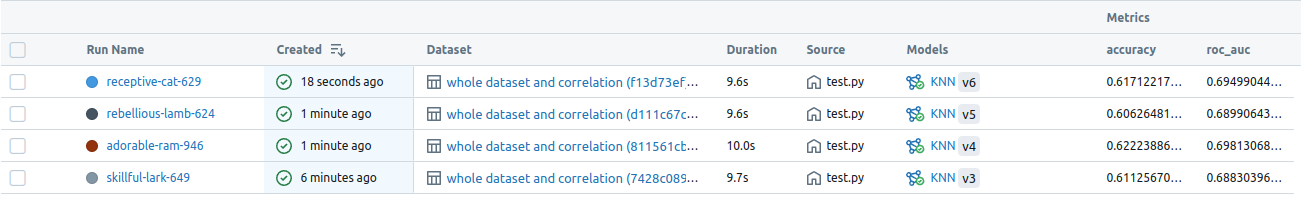

## Conclusion

This algorithm did not outperform the Random Forest algorithm, which was the best algorithm tested so far with a ROC AUC of 0.75. The team will continue to test other algorithms to find the best one for the dataset.